In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import os
import pandas as pd
from plugins import handleData

print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

testFiles = [
"root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_170to300_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/120000/0CDD30E0-B953-E54B-BB7A-BFB45BE6EC93.root",
"root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_300to470_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/120000/3788BBD3-3B70-BE48-B01A-4FA395E1E0B6.root",
"root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_470to600_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/F6B6A983-3E2B-7B4D-A2CE-E03AB6E32387.root",
"root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_600to800_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/FDF7FBE4-9226-994A-BD45-29995A3CD62F.root",
"root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_800to1000_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/2CEB03D7-5B1A-EE46-9C21-13ED3E349AF4.root",
"root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/DB87A517-0584-1A41-BB18-AAE7C9AAE5B8.root",
"root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/280000/BFE2E7E9-82CB-FE47-9B43-EBA5C373AF60.root",
"root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/5213B536-BAA1-CC43-A58A-B1E41E2680F5.root",
"root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/280000/E8400F91-3216-EA46-A9F1-8CC7EF5261B0.root",
"root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/280000/B21BFDD8-B878-784C-AFB6-5CDE131F5C39.root"
]

# redirector = 'root://cmsxrootd.fnal.gov/'
# files = handleData('fileset_QCD.json', redirector, testing = True, data = False)
# files_test = handleData('fileset_QCD.json', redirector, testing = False, data = False)
# print(files)
# print(files_test)

#/store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/7CB92FEA-6DFF-7647-9D7A-094D1F84245B.root has timeout error
# events = NanoEventsFactory.from_root(files[0], schemaclass=NanoAODSchema).events()

0.7.14


In [2]:
from coffea import processor, hist

#####
##### TO DO #####
# find misses --> need to do deltaR matching by hand --> if no reco miss
# do Rivet routine


class DijetHists(processor.ProcessorABC):
    def __init__(self, ptcut=30., etacut = 2.5):
        # should have separate lower ptcut for gen
        self.ptcut = ptcut
        self.etacut = etacut
        dataset_cat = hist.Cat("dataset", "Dataset")
        jet_cat = hist.Cat("jetNumb", "Jet")
        parton_cat = hist.Cat("partonFlav", "Parton Flavour")
        mass_bin = hist.Bin("mass", "Jet Mass (GeV)", 50, 0, 500.)
        mass_gen_bin = hist.Bin("mass", "Gen Jet Mass (GeV)", 100, 0, 500.)
        pt_bin = hist.Bin("pt", "Jet pT (GeV)", 60, 0, 2400.)
        bdisc_bin = hist.Bin("bdisc", "B-tag discriminator", 10, 0.0, 1.)
        frac_bin = hist.Bin("gfrac", "Gluon fraction", 10, 0.0, 1.)
        eta_bin = hist.Bin("eta", "Eta", 25, -2.5, 2.5)
        self._histos = processor.dict_accumulator({
        'jet_pt':             hist.Hist("Events", jet_cat, parton_cat, pt_bin),
#        'jet_pt_m':           hist.Hist("Events", jet_cat, pt_bin, mass_bin),  #why did I need this hist?
        'jet_eta':            hist.Hist("Events", jet_cat, parton_cat, eta_bin),
        'jet_mass':           hist.Hist("Events", jet_cat, parton_cat, mass_bin),
#        'misses_pt_m':        hist.Hist("Events", pt_bin, mass_gen_bin),
#        'fakes_pt_m':         hist.Hist("Events", pt_bin, mass_bin),
        'jet_response':       hist.Hist("Events", pt_bin, mass_bin, pt_bin, mass_gen_bin),
#        'genjet_pt':          hist.Hist("Events", pt_bin),
#        'genjet_eta':         hist.Hist("Events", eta_bin),
#        'genjet_mass':        hist.Hist("Events", mass_bin),
        'weights':            hist.Hist("Events", dataset_cat, hist.Bin("weights", "gen weights", 60, 0, 1.)),
#         'gluonPurity':      hist.Hist("Events", jet_cat, frac_bin),
        'gluonPurity':        processor.defaultdict_accumulator(int),
        'nGluonJets':         processor.defaultdict_accumulator(int),
        'cutflow':            processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._histos
    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        dijetEvents = events[(ak.num(events.FatJet) >= 2) & (ak.num(events.GenJetAK8) >= 2)]
        
#         for i in range(0,10):
#             print("Check that jets and are ordered by pt: ", events.FatJet[i,:].pt, "\n")
#             print("and that gen jets are order by pt:", events.GenJetAK8[i,:].pt, "\n")
        
        #get leading 2 jets
        fatJets = dijetEvents.FatJet[:,0:2]
        genJets = dijetEvents.GenJetAK8[:,0:2]
        
#         print("FatJet fields ", fatJets.fields, "\n")
#         print("GenJet fields ", genJets.fields, "\n")
        
        
        jet1 = dijetEvents.FatJet[:,0]
        jet2 = dijetEvents.FatJet[:,1]
        genjet1 = dijetEvents.GenJetAK8[:,0]
        genjet2 = dijetEvents.GenJetAK8[:,1]
        
        print("Initial # of dijet events ", len(fatJets), " and gen dijet events ", len(genJets), "\n")
        
        #calculate dphi_min
        dphi12 = (np.abs(jet1.delta_phi(jet2)) > 2.)
        dphi12_gen = (np.abs(genjet1.delta_phi(genjet2)) > 2.)
        
        #apply dphi gen and reco selection, pt cuts
        #see CMS PAS SMP-20-010 for selections
        
        
        #want to implement pt > 200GeV to be consistent with dijets?
        pt_cut = ak.all(dijetEvents.FatJet.pt > self.ptcut, axis = -1)
        pt_cut_gen = ak.all(dijetEvents.GenJetAK8.pt > self.ptcut, axis = -1)
        
        eta_cut = ak.all(np.abs(dijetEvents.FatJet.eta) < self.etacut, axis = -1)
        eta_cut_gen = ak.all(np.abs(dijetEvents.GenJetAK8.eta) < self.etacut, axis = -1)
        
        asymm = np.abs(jet1.pt - jet2.pt)/(jet1.pt + jet2.pt)
        asymm_gen  = np.abs(genjet1.pt - genjet2.pt)/(genjet1.pt + genjet2.pt)
        
        dijetEvents = dijetEvents[eta_cut & eta_cut_gen & (asymm < 0.3) & (asymm_gen < 0.3) & 
                                  pt_cut & dphi12 & pt_cut_gen & dphi12_gen]
        
        print("# of dijet events after eta cut", len(dijetEvents.FatJet), " and gen dijet events ", len(dijetEvents.GenJetAK8), "\n")
                
        #match jets
        matched = ~ak.any(ak.is_none(dijetEvents.FatJet.matched_gen, axis = -1), axis = -1)
        print("Length of matched ", len(matched))
        # NEED TO MAKE DELTA R MATCHING FOR GEN TO FIND MISSES
        #matched_gen = ~ak.is_none(DNE)
        
        
        # fakes are events reconstructed but does not exist in MC
        fakes = dijetEvents.FatJet[ak.any(ak.is_none(dijetEvents.FatJet.matched_gen, axis = -1), axis = -1)]
        print("Number of fake jets ", len(fakes))
        
        #miss = jet in MC but not reconstructed
        
        #misses = genJets[ak.is_none(DNE)]
        
        dijetEvents = dijetEvents[matched]
        print("Number of matched dijet events", len(dijetEvents))
#         print("Check for none values", ak.any(ak.is_none(dijetEvents, axis = -1)))
        
        jet = dijetEvents.FatJet[:,:2]
        genjet = dijetEvents.GenJetAK8[:,:2]
        
        jet1 = dijetEvents.FatJet[:,0]
        jet2 = dijetEvents.FatJet[:,1]
        genjet1 = dijetEvents.GenJetAK8[:,0]
        genjet2 = dijetEvents.GenJetAK8[:,1]
        
        #flavour --> 21 is gluon
        
        jet2_g     = jet2[np.abs(genjet2.partonFlavour) == 21]
        jet2_uds   = jet2[np.abs(genjet2.partonFlavour) < 4]
        jet2_c     = jet2[np.abs(genjet2.partonFlavour) == 4]
        jet2_b     = jet2[np.abs(genjet2.partonFlavour) == 5]
        jet2_other = jet2[(np.abs(genjet2.partonFlavour) > 5) & (np.abs(genjet2.partonFlavour) != 21)]
        
        jet1_g     = jet1[np.abs(genjet1.partonFlavour) == 21]
        jet1_uds   = jet1[np.abs(genjet1.partonFlavour) < 4]
        jet1_c     = jet1[np.abs(genjet1.partonFlavour) == 4]
        jet1_b     = jet1[np.abs(genjet1.partonFlavour) == 5]
        jet1_other = jet1[(np.abs(genjet1.partonFlavour) > 5) & (np.abs(genjet1.partonFlavour) != 21)]
        
#        #cant do jet_g = jet[jet.partonFlavor == 21] bc this would select events where either jet1 or jet2 is a gluon and keep both jets
#        #jet_g = ak.concatenate((jet1_g, jet2_g), axis = 0)
#        jet_cat = ak.concatenate((jet1, jet2), axis = 0)
#        print("check that total jet cat would work same way. length of concat'd jets", len(ak.concatenate((jet1, jet2), axis = 0)))
#        print(" and flattened jets ",  len(ak.flatten(dijetEvents.FatJet[:,:2])), "\n")
        
#        #make central and forward categories instead of jet1 jet2
#         print("Number of gluon jets = ", len(jet1_g)+len(jet2_g), " or ", len(jet_g))
        
        
        out['jet_mass'].fill(jetNumb = "jet1", partonFlav = "Gluon",  mass = jet1_g.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet1", partonFlav = "UDS",    mass = jet1_uds.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet1", partonFlav = "Charm",  mass = jet1_c.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet1", partonFlav = "Bottom", mass = jet1_b.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet1", partonFlav = "Other",  mass = jet1_other.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet2", partonFlav = "Gluon",  mass = jet2_g.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet2", partonFlav = "UDS",    mass = jet2_uds.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet2", partonFlav = "Charm",  mass = jet2_c.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet2", partonFlav = "Bottom", mass = jet2_b.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet2", partonFlav = "Other",  mass = jet2_other.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        
        out['jet_pt'].fill(jetNumb = "jet1", partonFlav = "Gluon",  pt = jet1_g.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet1", partonFlav = "UDS",    pt = jet1_uds.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet1", partonFlav = "Charm",  pt = jet1_c.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet1", partonFlav = "Bottom", pt = jet1_b.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet1", partonFlav = "Other",  pt = jet1_other.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet2", partonFlav = "Gluon",  pt = jet2_g.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet2", partonFlav = "UDS",    pt = jet2_uds.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet2", partonFlav = "Charm",  pt = jet2_c.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet2", partonFlav = "Bottom", pt = jet2_b.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet2", partonFlav = "Other",  pt = jet2_other.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )

        out['jet_eta'].fill(jetNumb = "jet1", partonFlav = "Gluon",  eta = jet1_g.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet1", partonFlav = "UDS",    eta = jet1_uds.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet1", partonFlav = "Charm",  eta = jet1_c.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet1", partonFlav = "Bottom", eta = jet1_b.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet1", partonFlav = "Other",  eta = jet1_other.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet2", partonFlav = "Gluon",  eta = jet2_g.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet2", partonFlav = "UDS",    eta = jet2_uds.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet2", partonFlav = "Charm",  eta = jet2_c.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet2", partonFlav = "Bottom", eta = jet2_b.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet2", partonFlav = "Other",  eta = jet2_other.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )

        #NOTE --> need gen sd mass eventually --> recluster :( 
#         out['genjet_mass'].fill(
#             mass=ak.flatten(genjet.mass),
#             #weight=ak.flatten(dijetEvents.Generator.weight[~ak.is_none(dijetEvents.FatJet[:,0].matched_gen)])
#         )
            
#         out['weights'].fill(
#             dataset=events.metadata["dataset"],
#             weights=dijetEvents.Generator.weight,
#         )     
#         out['btag'].fill(
#             partonFlav = "Bottom",
#             bdisc=ak.flatten(jet_b.btagCSVV2),
#         )
        out['cutflow']['chunks'] += 1
        out['cutflow']['nGluonJets'] += (len(jet[np.abs(genjet.partonFlavour) == 21]))
        return out
    
    def postprocess(self, accumulator):
        return accumulator

In [9]:
from dask.distributed import Client

#switch to if name and arg parse instead of separate function?
def runCoffeaJob(processor_inst, json = 'fileset_QCD.json', lpc = False, casa = False, testing = False):
    #default is to run locally
    tstart = time.time()
    executor = processor.futures_executor
    redirector = 'root://cmsxrootd.fnal.gov/'
    casa_redirector = 'root://xcache/'
    exe_args = {"schema": NanoAODSchema, 'skipbadfiles': True,}
    #samples = samples = { "QCD": testFiles }
    samples = handleData(json, redirector, testing = testing)
    client = None
    if casa:
        print("Running on coffea casa")
        from coffea_casa import CoffeaCasaCluster
        from dask.distributed.diagnostics.plugin import UploadDirectory #do i need this?
        client = Client("tls://lauren-2emeryl-2ehay-40cern-2ech.dask.cmsaf-prod.flatiron.hollandhpc.org:8786")
        samples = handleData(json, casa_redirector, testing = testing)
        exe_args = {
            "client": client,
            'skipbadfiles':True,
            "schema": NanoAODSchema,
            "align_clusters": True,
        }
        executor = processor.dask_executor
    elif lpc:
        print("Running on LPC Condor")
        from lpcjobqueue import LPCCondorCluster
        cluster = LPCCondorCluster(shared_temp_directory="/tmp")
        #### minimum > 0: https://github.com/CoffeaTeam/coffea/issues/465
        cluster.adapt(minimum=1, maximum=10)
        client = Client(cluster)
        exe_args = {
            "client": client,
            'skipbadfiles':True,
            "savemetrics": True,
            "schema": NanoAODSchema,
            "align_clusters": True,
        }
#         print("Waiting for at least one worker...")
        client.wait_for_workers(1)
        executor = processor.dask_executor
    else:
        print("Running locally")
    result = processor.run_uproot_job(samples,
                                      "Events",
                                      processor_instance = processor_inst,
                                      executor = executor,
                                      executor_args = exe_args,
                                      chunksize = 1000,
                                      maxchunks = 1,
                                     )
    elapsed = time.time() - tstart
    print(result)
    print("Time taken to run over samples ", elapsed)
    return result

result = runCoffeaJob(DijetHists(), casa = True, testing = True)
util.save(result, 'coffeaOutput/DiJet_pT30_eta25_result.coffea')


Running on coffea casa
[#                                       ] | 2% Completed |  0.1s

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:850: RuntimeWarning: Allocating a large (>10M bin) histogram!
  warnings.warn("Allocating a large (>10M bin) histogram!", RuntimeWarning)


{'jet_pt': <Hist (jetNumb,partonFlav,pt) instance at 0x7f00e0828d60>, 'jet_eta': <Hist (jetNumb,partonFlav,eta) instance at 0x7f00e0828dc0>, 'jet_mass': <Hist (jetNumb,partonFlav,mass) instance at 0x7f00e07f8370>, 'jet_response': <Hist (pt,mass,pt,mass) instance at 0x7f00e07f8c70>, 'weights': <Hist (dataset,weights) instance at 0x7f00e07f8be0>, 'gluonPurity': defaultdict_accumulator(<class 'int'>, {}), 'nGluonJets': defaultdict_accumulator(<class 'int'>, {}), 'cutflow': defaultdict_accumulator(<class 'int'>, {'chunks': 30, 'nGluonJets': 27105})}
Time taken to run over samples  34.66627049446106



<Hist (pt) instance at 0x7f00e0c0e550> <Hist (pt) instance at 0x7f00e0c22f40>


/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


(0.0, 1.0)

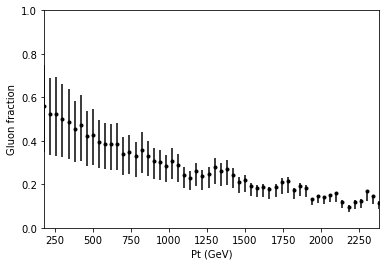

In [4]:
print()
import matplotlib.pyplot as plt


numerator = result['jet_pt'].integrate('partonFlav','Gluon').sum('jetNumb')
denominator = result['jet_pt'].sum('partonFlav').sum('jetNumb')
print(numerator, denominator)

numerator.label = r'$\epsilon$'
ax = hist.plotratio(
    num=numerator,
    denom=denominator,
    error_opts={'color': 'k', 'marker': '.'},
    unc='poisson-ratio'
)

# glu = result['jet_pt'].sum('jetNumb').values()[('Gluon',)]
# tot_parton = result['jet_pt'].sum('jetNumb').values()[('All',)]

# print("Check for nan values in tot_parton ", np.isnan(tot_parton))

# glu_frac = np.where(tot_parton > 0, np.divide(glu,tot_parton), 0)

# print(len(result['jet_pt'].axis('pt').centers()))
# print(result['jet_pt'].to_hist())

# print(glu_frac)

# plt.scatter(result['jet_pt'].axis('pt').centers(), glu_frac)

plt.xlabel("Pt (GeV)")
plt.ylabel("Gluon fraction")
plt.ylim([0.,1.0])


<Hist (eta) instance at 0x7f00e0a64f40> <Hist (eta) instance at 0x7f00e09fc0a0>


(0.0, 1.0)

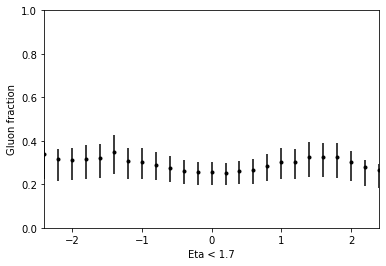

In [5]:
numerator = result['jet_eta'].integrate('partonFlav','Gluon').sum("jetNumb")
denominator = result['jet_eta'].sum('partonFlav').sum("jetNumb")

print(numerator, denominator)

numerator.label = r'$\epsilon$'
ax = hist.plotratio(
    num=numerator,
    denom=denominator,
    error_opts={'color': 'k', 'marker': '.'},
    unc='poisson-ratio'
)

plt.xlabel("Eta < 1.7")
plt.ylabel("Gluon fraction")
plt.ylim([0.,1.0])


<Hist (partonFlav,mass) instance at 0x7f00e09deb80>


/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


Text(0.5, 0, 'Jet mass (GeV)')

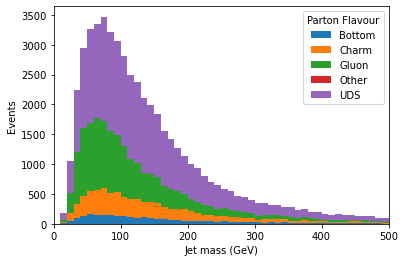

In [6]:
#sum entries in bins --> plot as y-axis

%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (20,5)


# fig, axs = plt.subplots(1, 3)
print(result['jet_mass'].sum('jetNumb'))
hist.plot1d(result['jet_mass'].sum('jetNumb'), stack = True)
#axs[0].set_xlabel("Jet mass (GeV)")
plt.xlabel("Jet mass (GeV)")

Text(0.5, 0, 'Jet pT (GeV)')

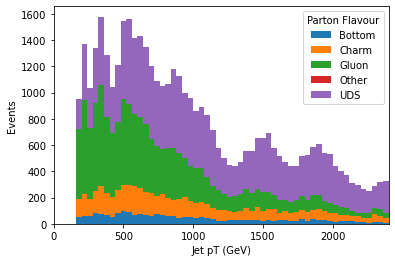

In [7]:
fig, ax = plt.subplots(1, 1)
hist.plot1d(result['jet_pt'].sum('jetNumb'), stack = True)
ax.set_xlabel("Jet pT (GeV)")
# ax.set_xscale("log")
# ax.set_xlim([170., 2000.])

In [8]:
#plot pt, eta, phi, fake rate, pt efficiency, gluon purity for difference selections with b tags for all jets 
#and each individual jet in the 3 jets